In [1]:
import torch
from torch import nn, optim
import cv2
import numpy as np
import torch.fft
import time
import matplotlib.pyplot as plt
import math
from skimage import io
import os
import scipy.io as scio
%matplotlib inline
from PIL import Image
from model import Net

magnification_factor=1.3e5
image_size = 64

t0=time.process_time()
print(torch.cuda.is_available())

True


Define the signal to be transmitted

[0.31690141 0.40140845 0.61267606 0.84507042 0.57746479 0.28169014
 0.26760563 0.30985915 0.54225352 0.33098592 0.23239437 0.34507042
 0.8028169  0.70422535 0.38028169 0.95774648 0.97183099 0.88028169
 0.26056338 0.43661972 0.41549296 0.42957746 0.61971831 0.52816901
 0.67605634 0.73943662 0.66197183 0.64788732 0.75352113 0.68309859
 0.77464789 0.51408451 0.69014085 0.52816901 0.45070423 0.53521127
 0.29577465 0.6971831  0.59859155 0.78873239 0.78169014 0.52112676
 0.71830986 0.61267606 0.66901408 0.70422535 0.80985915 1.
 0.99295775 0.54225352 0.3943662  0.42957746 0.59859155 0.44366197
 0.38732394 0.38732394 0.38028169 0.28169014 0.3028169  0.66901408
 0.67605634 0.64788732 0.3943662  0.47183099]


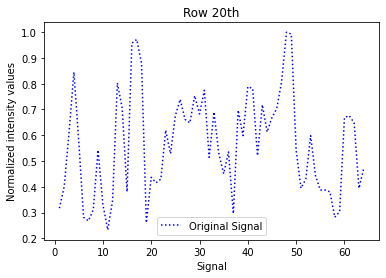

In [2]:
#lr=0.0001
lr=0.01
model = Net(n_channels=1, n_classes=1, bilinear=False)
criterion = nn.MSELoss()

if torch.cuda.is_available():
    model.cuda()

optvars = [{'params': model.parameters()}]
optimizier = torch.optim.Adam(optvars, lr=lr)

path='./images/BSD100_088.png'

img = cv2.imread(path)
img2 = cv2.resize(img, (image_size,image_size))
gray = cv2.split(img2)[2]

gray=gray/255
row=30

# obtain the original signal 
gray=gray[row,:]
gray=gray/np.max(gray)

filename,_=os.path.splitext(os.path.basename(path))
scio.savemat(('./signal_mat/{}_{}.mat'.format(filename,row)),{'data':gray})
gray_res=gray.flatten()
print(gray)

gray_res=torch.from_numpy(gray_res)
gray_res_cuda=gray_res.cuda()
gray_res_cuda = gray_res_cuda.double()

#plt.figure(figsize=(10,10))
#plt.imshow(gray,cmap='gray')
signal=[]
for i in range(65):
    if i>0:
        signal.append(i)
plt.plot(signal,gray, label='Original Signal', color='blue', linestyle=':')

plt.xlabel('Signal')
plt.ylabel('Normalized intensity values')
plt.title('Row 20th')
plt.legend()   
plt.pause(1.0)

In [3]:
def ts_to_np(ts):
    
    return ts.detach().cpu().squeeze().numpy()
def np_to_ts(np):
    return torch.tensor(np).unsqueeze(0)


In [4]:
def plot_loss_save(k,iters,y_loss,loss):
    #plt.cla()
    iters.append(k)
    loss_np=ts_to_np(loss)
    y_loss.append(loss_np)                 
      

def plot_loss(iters,y_loss):
    plt.plot(iters, y_loss, label='Loss rate', color='g')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title('loss')
    plt.legend()   
    plt.pause(1.0)

The fixed input of the UNN

tensor([[[[0.0272, 0.0534, 0.0441,  ..., 0.0236, 0.0359, 0.0148],
          [0.0426, 0.0830, 0.0941,  ..., 0.0694, 0.0850, 0.0036],
          [0.0454, 0.0850, 0.0022,  ..., 0.0450, 0.0882, 0.0763],
          ...,
          [0.0088, 0.0941, 0.0948,  ..., 0.0990, 0.0084, 0.0648],
          [0.0443, 0.0128, 0.0605,  ..., 0.0722, 0.0847, 0.0116],
          [0.0284, 0.0614, 0.0482,  ..., 0.0501, 0.0705, 0.0661]]]],
       device='cuda:0')


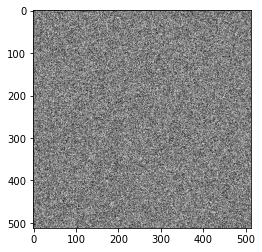

In [5]:
#Input of unn
img_amp=torch.zeros(1,1,512,512)
input_random = img_amp.uniform_()*0.1
net_input =input_random.cuda() 
net_input_saved = net_input.detach().clone()

net_input_np=ts_to_np(net_input)
plt.figure()
plt.imshow(net_input_np,cmap='gray')
print(net_input)

3.602451670303708e-12


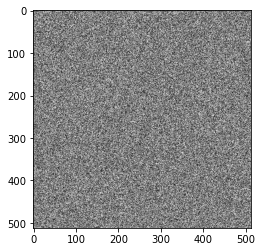

In [6]:
# add gaussian noise in the pattern due to the experimental consideration
gaussian_rand=np.random.random((512,512))
gaussian_rand=gaussian_rand-np.mean(gaussian_rand)
plt.figure()
plt.imshow(gaussian_rand,cmap='gray')
print(np.sum(gaussian_rand))

Generate a series of random amplitude-only patterns with UNN

In [7]:
#generated measurements by unn: result
result=[]
ii=1

#pattern directory
os.makedirs('./pattern_13_{}_row{}/'.format(filename,row),exist_ok=True)
path_pattern=os.path.join('./pattern_13_{}_row{}/'.format(filename,row))

#loop to generate a series of random amplitude-only patterns
for i in range(64):
    iters=[]
    y_loss=[]
    
    model =  Net(n_channels=1, n_classes=1, bilinear=False)
    criterion = nn.MSELoss()

    if torch.cuda.is_available():
        model.cuda()

    optvars = [{'params': model.parameters()}]
    optimizier = torch.optim.Adam(optvars, lr=lr)
    loss_item=1
    k=0
    while(loss_item>1e-15):
        output = model(net_input)
        #output=torch.sigmoid(output)

        output = torch.squeeze(output)

        #output=output/torch.max(abs(output))
  
        recons = torch.fft.fftn(output)
      
        final = recons
        final = final.double()
        #print(final)
        final_spi = final[0][0]/magnification_factor
        #print(final_spi)
        
        loss = criterion(final_spi,gray_res_cuda[i])
        loss_item=ts_to_np(loss)
        plot_loss_save(k,iters,y_loss,loss)
        optimizier.zero_grad()

        loss.backward()
        optimizier.step()

        print ('LOOP %02d, Iteration %05d, loss %.20f ' % (i,k, loss.item()), '\r', end='')
        k=k+1
        if k>2000:
            break
        
    final_np=final_spi.detach().cpu().numpy()
    result.append(final_np)
    
    output=output.detach().cpu().numpy()
         
    output = (output+gaussian_rand)/2
    output_1 = (1+output)/2
    output_2 = (1-output)/2
    
    numm_1=str(ii).rjust(5,'0')
    numm_2=str(ii+1).rjust(5,'0')
    path_1=path_pattern+numm_1+'.png'
    path_2=path_pattern+numm_2+'.png'
    io.imsave(path_1,output_1)
    io.imsave(path_2,output_2)
    
    ii=ii+2

C:\Users\PengYang\AppData\Local\Temp\ipykernel_14156\1339246538.py:35: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ..\aten\src\ATen\native\Copy.cpp:162.)
  final = final.double()


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [8]:
print("time:",time.process_time()-t0)

result=np.array(result)

print(result)

time: 432.21875
[0.31690141 0.40140844 0.61267608 0.84507043 0.57746478 0.28169014
 0.26760562 0.30985913 0.54225355 0.33098594 0.23239435 0.34507043
 0.80281689 0.70422536 0.3802817  0.95774645 0.97183101 0.88028167
 0.2605634  0.43661971 0.41549297 0.42957749 0.61971827 0.52816899
 0.67605631 0.7394366  0.66197181 0.64788738 0.75352115 0.68309862
 0.7746479  0.5140845  0.69014087 0.52816899 0.45070424 0.5352113
 0.29577467 0.69718311 0.59859153 0.78873239 0.78169014 0.52112674
 0.71830986 0.61267608 0.66901406 0.70422536 0.80985913 1.
 0.99295775 0.54225355 0.39436617 0.42957749 0.59859153 0.44366196
 0.38732392 0.38732392 0.38028167 0.28169014 0.30281692 0.66901406
 0.67605631 0.64788732 0.39436623 0.47183098]


In [9]:
result_norm=result/np.max(result)

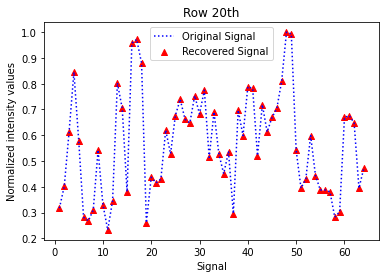

In [10]:
plt.plot(signal,gray, label='Original Signal', color='blue', linestyle=':')
plt.scatter(signal,result_norm, label='Recovered Signal',color='red',marker='^')
plt.xlabel('Signal')
plt.ylabel('Normalized intensity values')
plt.title('Row 20th')
plt.legend()   
plt.pause(1.0)

Calculate the PSNR and SSIM

In [11]:
import numpy as np

mse_value = np.mean((result_norm-gray)**2)
print("mse_value:",mse_value)
#mse_value=total_loss.item()
if mse_value<1.0e-10:
    PSNR= 100
PIXEL_MAX=np.max(result_norm)
PSNR=20*math.log10(1/math.sqrt(mse_value))
print("PSNR:",PSNR)

mse_value: 4.24907391037856e-16
PSNR: 153.71705714523478


Test the quality of the signal encoded into the generated random pattern

In [13]:
all_pixel_list=[]
k=1

rand_1=np.random.random((512,512))

rand_2=np.random.random((512,512))
for i in range(64):
    patternpath1 = path_pattern+str(k).rjust(5,'0')+'.png'
    patternpath2 = path_pattern+str(k+1).rjust(5,'0')+'.png'
    img_1=Image.open(patternpath1)
    img_1=np.array(img_1)
    img_2=Image.open(patternpath2)
    img_2=np.array(img_2)
    all_pixel=abs(np.sum(img_1)-np.sum(img_2))/magnification_factor
    
    all_pixel_list.append(all_pixel/255)
    
    k=k+2


In [14]:
res=np.array(all_pixel_list)
res=res/np.max(res)
print(res)
mse_value = np.mean((res-gray)**2)
print("mse_value:",mse_value)
#mse_value=total_loss.item()
if mse_value<1.0e-10:
    PSNR= 100
PIXEL_MAX=np.max(res)
PSNR=20*math.log10(1/math.sqrt(mse_value))
print("PSNR:",PSNR)

[0.31687085 0.40144622 0.61270661 0.8450909  0.57745678 0.28169644
 0.26761191 0.30986454 0.54223713 0.33095164 0.23241723 0.34507298
 0.80286602 0.70421142 0.38030868 0.95776173 0.97184723 0.88031357
 0.26057906 0.43660941 0.41551615 0.4296025  0.61976227 0.52816176
 0.67604996 0.73945497 0.66196193 0.64790117 0.7535348  0.68312782
 0.77466546 0.5141284  0.69017443 0.52824708 0.45072592 0.53523637
 0.29574671 0.69724349 0.59861906 0.78877593 0.78169457 0.52113555
 0.71833397 0.61271216 0.66903714 0.70423218 0.80988994 1.
 0.99302096 0.54227671 0.39437005 0.42959176 0.59862606 0.44368751
 0.387374   0.38729472 0.38028902 0.28166012 0.30278982 0.66905162
 0.67605973 0.64790998 0.39439841 0.47182001]
mse_value: 8.093091854361676e-10
PSNR: 90.9188553045682
